In [1]:
import jax
import jax.numpy as jnp
from typing import NamedTuple, Callable, Optional
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from tqdm import tqdm
from pathlib import Path
from functools import cache

In [2]:
visualize = True

In [3]:
# all calculations are done in the cartesian plane.
# we only transform to pixel coordinates when drawing
DIRECTIONS = jnp.array([(1, 0), (0, 1), (-1, 0), (0, -1)])
ND = len(DIRECTIONS)
RIGHT, UP, LEFT, DOWN = range(ND)  # in clockwise order
# TODO make sure to generalize this for arbitrary directions
OPPOSITE_DIRS = jnp.arange(ND) ^ 2

Position = jnp.ndarray  # (x, y)
TileType = int  # index into the tileset
TileTypeArray = jnp.ndarray  # (tileset_size,)
DirectionSet = jnp.ndarray  # (<= ND,)

In [4]:
# What we're building towards. The functions will all be defined later.
def solve_wfc(
    tileset_path: str, tileset_images: str, w: int, h: int, max_seeds=16, max_steps=1024
) -> tuple[list["State"], list[list["Ban"]]]:
    tileset = load_tileset(tileset_path, tileset_images)
    patterns = load_patterns(tileset)
    propagator = create_propagator(tileset, patterns)
    problem = Problem(patterns["weight"].values, propagator)
    for seed in range(max_seeds):
        state = init_state(problem, w, h)
        key = jax.random.PRNGKey(seed)
        print(f"Running seed {seed}")
        states, histories, solved = run_wfc(key, state, problem, max_steps=max_steps)
        if solved:
            return states, histories
    raise RuntimeError("Could not find a solution")

# Constructing the Tileset

In [5]:
class Tileset(NamedTuple):
    tiles: pd.DataFrame
    neighbors: pd.DataFrame
    subsets: dict[str, pd.DataFrame]

    def symmetry_name(self, tile: str) -> str:
        return self.tiles.at[tile, "symmetry"]

    def symmetry(self, name: str) -> "Symmetry":
        """Get the symmetry object of a tile."""
        # SYMMETRIES defined later
        return SYMMETRIES[self.symmetry_name(name)]

    def load_img(self, name: str, spin: int = 0) -> np.ndarray:
        # swap the rows and columns for the rotation to make sense
        img = self.tiles.loc[name, "img"]
        img = np.rot90(img, spin)
        return img

    def get_subset(self, name: str) -> TileTypeArray:
        tiles = self.subsets[name].values
        neighbors = self.neighbors.applymap(lambda x: x[0]).isin(tiles).any(axis=1)
        return Tileset(self.tiles.loc[tiles], self.neighbors[neighbors], {})


def _preprocess(row):
    """Turn a name in the 'neighbors' table into a (name, spin) pair for indexing into the df."""
    left, right = row
    left, right = left.split(" "), right.split(" ")
    if len(left) == 1:
        left += ["0"]
    if len(right) == 1:
        right += ["0"]
    return {"left": (left[0], int(left[1])), "right": (right[0], int(right[1]))}


def load_tileset(path: str, images: str) -> Tileset:
    """Load a tileset from an XML file and a directory of images."""
    groups = ["tiles", "neighbors", "subsets"]
    tiles, neighbors, subsets = [
        pd.read_xml(path, xpath=f"./{group}/*") for group in groups
    ]

    # preprocess the tiles dataframe
    tiles = tiles.set_index("name")
    tiles["img"] = tiles.index.map(
        lambda name: plt.imread(Path(images) / f"{name}.png")
    )

    # preprocess neighbors
    neighbors = neighbors.apply(_preprocess, axis=1, result_type="expand")

    # preprocess the subsets
    subsets = {
        name: pd.read_xml(path, xpath=f'./subsets/subset[@name="{name}"]/*')["name"]
        for name in subsets["name"]
    }

    return Tileset(tiles, neighbors, subsets)

In [6]:
circuit_tileset = load_tileset("./tilesets/Circuit.xml", "./tilesets/Circuit")
circuit_tileset.tiles

,symmetry,weight,img
name,,,
bridge,I,1.0,"[[[0.019607844, 0.4117647, 0.039215688], [0.01..."
component,X,20.0,"[[[0.20784314, 0.20784314, 0.20784314], [0.207..."
connection,T,10.0,"[[[0.019607844, 0.4117647, 0.039215688], [0.01..."
corner,L,10.0,"[[[0.019607844, 0.4117647, 0.039215688], [0.01..."
substrate,X,2.0,"[[[0.019607844, 0.4117647, 0.039215688], [0.01..."
t,T,0.1,"[[[0.019607844, 0.4117647, 0.039215688], [0.01..."
track,I,2.0,"[[[0.019607844, 0.4117647, 0.039215688], [0.01..."
transition,T,0.4,"[[[0.019607844, 0.4117647, 0.039215688], [0.01..."
turn,L,1.0,"[[[0.019607844, 0.4117647, 0.039215688], [0.01..."


In [7]:
circuit_tileset.neighbors

,left,right
0,"(bridge, 0)","(bridge, 0)"
1,"(bridge, 1)","(bridge, 1)"
2,"(bridge, 1)","(connection, 1)"
3,"(bridge, 1)","(t, 2)"
4,"(bridge, 1)","(t, 3)"
...,...,...
140,"(vias, 0)","(skew, 0)"
141,"(vias, 1)","(skew, 0)"
142,"(vias, 2)","(skew, 0)"
143,"(vias, 3)","(skew, 2)"


## Tile rotations

I'll use "tile" to refer to the original, unrotated tiles, and "TILE" to refer to an element of the massive set of rotated tiles we obtain afterwards.

$C$ denotes the number of TILEs.

In [8]:
class Symmetry(NamedTuple):
    """
    A symmetry group.
    If (A > B) is compatible (i.e. A appears to the left of B),
    then the following should also be compatible:

    - rotate(A) ^ rotate(B)
    - flip(B) > flip(A)
    """

    card: int
    """The number of elements in the symmetry group."""

    rotate: Callable[[int], int]
    """Rotate this tile counterclockwise."""

    flip: Callable[[int], int]
    """Flip this tile horizontally."""


id = lambda i: i
rotate = lambda i: (i + 1) % 4
flipa = lambda i: i ^ 1
flipb = lambda i: jnp.where(i % 2 == 0, i, 4 - i)  # flips across the x-axis


SYMMETRIES = {
    "X": Symmetry(1, id, id),
    "L": Symmetry(4, rotate, flipa),
    "T": Symmetry(4, rotate, flipb),
    "I": Symmetry(2, flipa, id),
    "\\": Symmetry(2, flipa, flipa),
    "F": Symmetry(
        8, lambda i: jnp.where(i < 4, rotate(i), 4 + rotate(i)), lambda i: i ^ 4
    ),
}


def _get_symmetry(sym: Symmetry, t=0):
    s = []
    for _ in range(ND):
        s.append((t, sym.flip(t)))
        t = sym.rotate(t)
    return jnp.array(s)


@cache
def get_symmetries(symmetry_name: str) -> list[Symmetry]:
    s = SYMMETRIES[symmetry_name]
    return jax.vmap(_get_symmetry, in_axes=(None, 0))(s, jnp.arange(s.card))

In [9]:
def show_symmetries(tileset: Tileset, tile: str):
    fig, axs = plt.subplots(2, 5, figsize=(6, 2.2))

    symmetry = tileset.symmetry(tile)

    axs[0, 0].imshow(tileset.load_img(tile))
    axs[0, 0].axis("off")
    axs[0, 0].set_title(f"{tile} ({tileset.symmetry_name(tile)})")

    axs[1, 0].axis("off")

    for j, k in enumerate(_get_symmetry(symmetry)):
        i = j + 1
        k0, k1 = k[0].item(), k[1].item()
        axs[0, i].imshow(tileset.load_img(tile, k0))
        axs[1, i].imshow(tileset.load_img(tile, k1))
        axs[0, i].axis("off")
        axs[1, i].axis("off")
        axs[0, i].set_title(k0)
        axs[1, i].set_title(k1)

    plt.show()

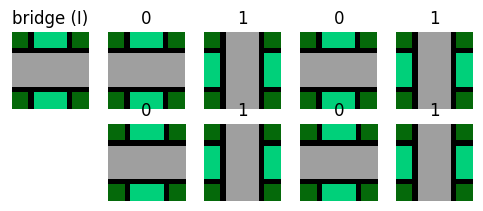

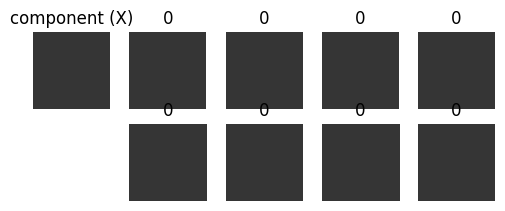

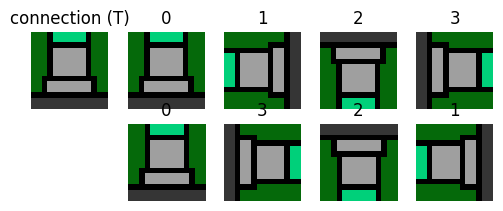

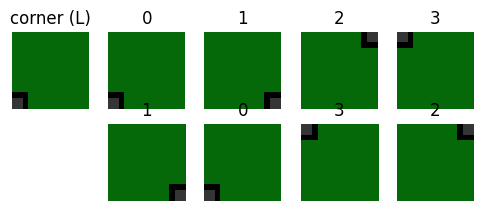

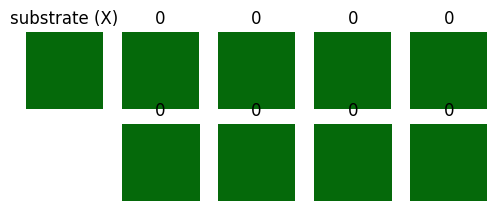

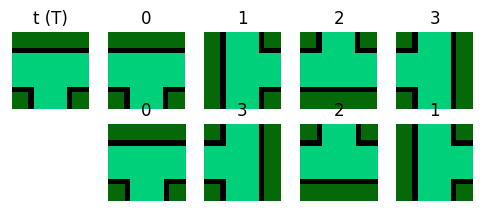

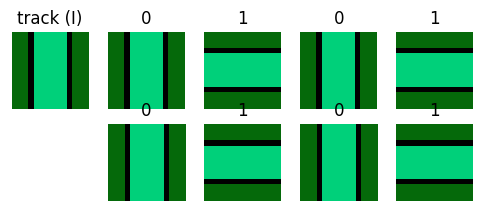

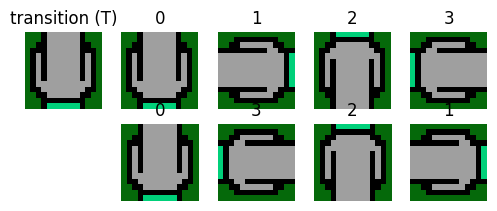

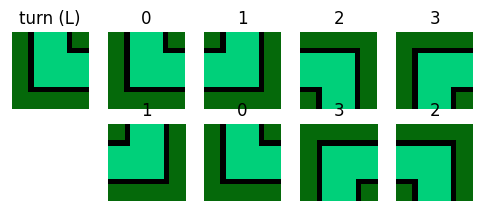

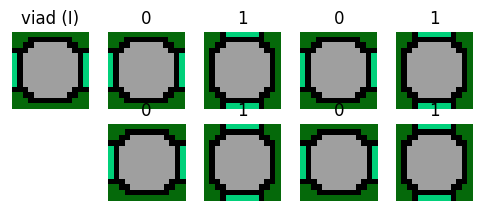

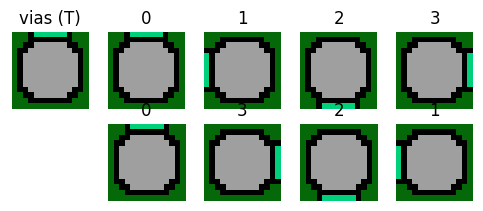

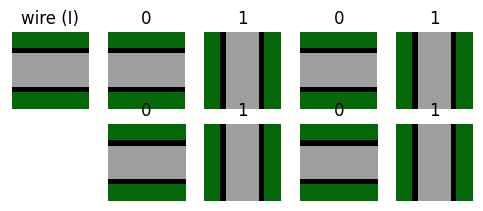

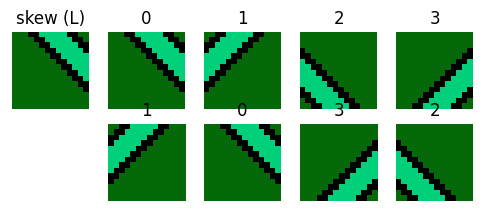

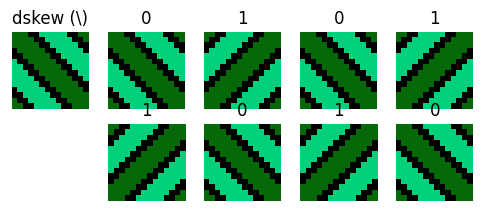

In [10]:
if visualize:
    for tile in circuit_tileset.tiles.index:
        show_symmetries(circuit_tileset, tile)

In [11]:
def load_patterns(tileset: Tileset):
    """
    Turns the set of tiles into the set of TILEs.
    """
    names = []
    spins = []
    stepsto = []
    weights = []

    for name, symmetry, weight, _ in tileset.tiles.itertuples():
        s = get_symmetries(symmetry)  # Shape (sym.card, 4, 2)
        card = s.shape[0]
        names.extend([name] * card)
        spins.extend(range(card))
        stepsto.extend(s + len(stepsto))
        weights.extend([weight] * card)

    index = pd.MultiIndex.from_arrays([names, spins], names=["name", "spin"])
    return pd.DataFrame(
        {
            "stepsto": stepsto,
            "weight": weights,
        },
        index=index,
    )

In [12]:
patterns = load_patterns(circuit_tileset)
patterns.reset_index()

,name,spin,stepsto,weight
0,bridge,0,"[[0, 0], [1, 1], [0, 0], [1, 1]]",1.0
1,bridge,1,"[[1, 1], [0, 0], [1, 1], [0, 0]]",1.0
2,component,0,"[[2, 2], [2, 2], [2, 2], [2, 2]]",20.0
3,connection,0,"[[3, 3], [4, 6], [5, 5], [6, 4]]",10.0
4,connection,1,"[[4, 6], [5, 5], [6, 4], [3, 3]]",10.0
5,connection,2,"[[5, 5], [6, 4], [3, 3], [4, 6]]",10.0
6,connection,3,"[[6, 4], [3, 3], [4, 6], [5, 5]]",10.0
7,corner,0,"[[7, 8], [8, 7], [9, 10], [10, 9]]",10.0
8,corner,1,"[[8, 7], [9, 10], [10, 9], [7, 8]]",10.0
9,corner,2,"[[9, 10], [10, 9], [7, 8], [8, 7]]",10.0


# Propagation

Great! Now that we have the set of rotations set up,
we need to be able to tell which tile types are allowed to be
next to each other. We'll do this with a `propagator` matrix defined below.

In [13]:
class _Indexer:
    def __getitem__(self, idx):
        return lambda x: x[idx].item()


_indexer = _Indexer()


def create_propagator(tileset: Tileset, patterns: pd.DataFrame) -> jnp.ndarray:
    """Shape (D, C, C). propagator[dir, from, to] is True if
    the tile `from` is compatible with tile `to` in direction `dir`.
    For example, propagator[RIGHT, L, R] means that the tile pattern L -> R is allowed.

    stepsto should be a dataframe returned by load_patterns.
    The multiindex should be (name, spin) and the columns are (stepsto, weight)."""

    pairl, pairr = tileset.neighbors["left"], tileset.neighbors["right"]
    lstep = patterns.loc[pairl, "stepsto"]
    rstep = patterns.loc[pairr, "stepsto"]
    d = lstep.map(_indexer[1, 0])
    u = rstep.map(_indexer[1, 0])
    dstep = patterns.iloc[d, 0]
    ustep = patterns.iloc[u, 0]

    transforms = [
        [0, 0],
        [0, 1],
        [2, 0],
        [2, 1],
    ]

    tuples = [
        *zip((lstep, rstep, rstep, lstep), transforms),  # left
        *zip((rstep, lstep, lstep, rstep), transforms),  # right
        *zip((dstep, dstep, ustep, ustep), transforms),  # down
        *zip((ustep, ustep, dstep, dstep), transforms),  # up
    ]

    indices = [
        step.map(_indexer[rotation, flip]).values for step, (rotation, flip) in tuples
    ]

    propagator = (
        jnp.zeros((ND, len(patterns), len(patterns)), dtype=np.bool_)
        .at[RIGHT, indices[0:4], indices[4:8]]
        .set(True)
        .at[UP, indices[8:12], indices[12:16]]
        .set(True)
    )

    propagator = (
        propagator.at[LEFT].set(propagator[RIGHT].T).at[DOWN].set(propagator[UP].T)
    )

    return propagator

In [14]:
propagator = create_propagator(circuit_tileset, patterns)
assert propagator.shape == (ND, len(patterns), len(patterns))

In [15]:
def plot_connections(tileset: Tileset, tile: str, spin=0, d=RIGHT):
    """Visualize the connections in the propagator for a given tile and direction."""
    idx = patterns.index.get_loc((tile, spin))
    (dst,) = jnp.nonzero(propagator[d, idx])  # list of possible destination tiles

    print(f"{tile} ({spin}) -> {len(dst)} options")

    fig, axs = plt.subplots(1, 1 + len(dst), figsize=(1 + len(dst), 1))

    axs[0].imshow(tileset.load_img(tile, spin))
    axs[0].axis("off")
    axs[0].set_title(f"{tile} {spin}")

    for i, j in enumerate(dst):
        name, spin = patterns.iloc[j.item()].name
        axs[i + 1].imshow(tileset.load_img(name, spin))
        axs[i + 1].axis("off")
        axs[i + 1].set_title(f"{name} {spin}")

    plt.show()

bridge (0) -> 14 options


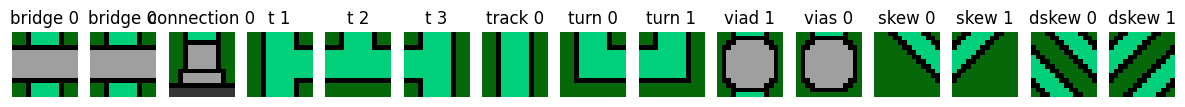

bridge (1) -> 3 options


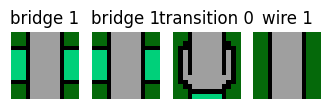

component (0) -> 2 options


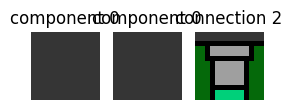

connection (0) -> 1 options


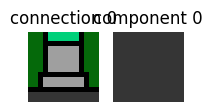

connection (1) -> 2 options


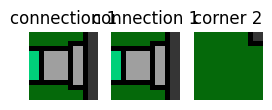

connection (2) -> 11 options


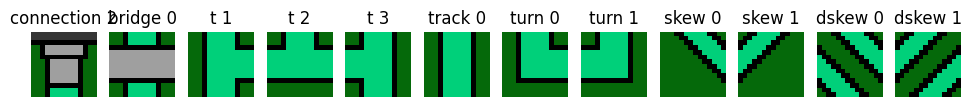

connection (3) -> 2 options


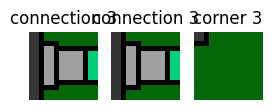

corner (0) -> 1 options


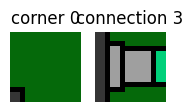

corner (1) -> 1 options


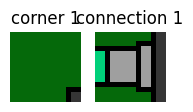

corner (2) -> 14 options


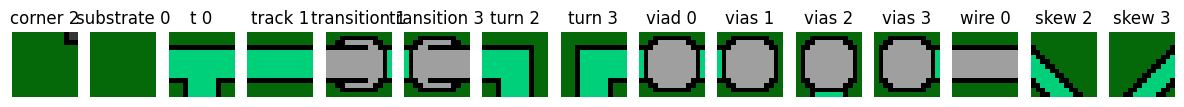

corner (3) -> 14 options


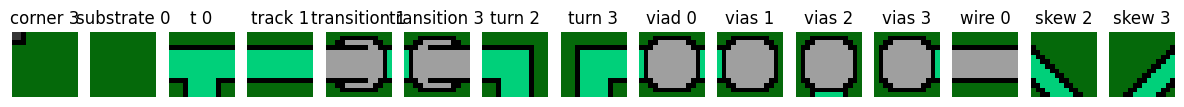

In [16]:
if visualize:
    # pick some of the tiles types to visualize their connections
    for tile in circuit_tileset.tiles.index[:4]:
        for spin in range(circuit_tileset.symmetry(tile).card):
            plot_connections(circuit_tileset, tile, spin, DOWN)

# WFC

Now let's build the actual algorithm for "collapsing the wave function"!
The "wave function" itself is a boolean array. For each (node, tile type) pair,
it tracks whether or not this pair is still valid.

## State and problem setup

In [17]:
class State(NamedTuple):
    """The state of the WFC algorithm."""

    wave: jnp.ndarray
    """Shape (W, H, C). wave[x, y, k] is True if pattern k is possible at
    position (x, y), and False otherwise."""

    compatible: jnp.ndarray
    """Shape (W, H, D, C). compatible[x, y, d, k] counts how many ways there are to get
    type k at position (x, y) _from_ direction d."""

    entropies: jnp.ndarray
    """Shape (W, H). The entropy of each position. Used for picking the next state."""

    def ntypes(self):
        return self.wave.shape[-1]

    def shape(self):
        return self.entropies.shape

    def positions(self):
        w, h = self.shape()
        return jnp.mgrid[:w, :h].reshape(2, -1).T

    def counts(self):
        return self.wave.sum(axis=-1)

    def neighbors(self, node: Position):
        # TODO check for periodic case
        p = node + DIRECTIONS
        bounds = jnp.array(self.shape())
        # don't pick collapsed nodes
        in_bounds = ((p >= 0) & (p < bounds)).all(axis=-1)
        collapsed = self.is_collapsed()[p[:, 0], p[:, 1]]
        (dirs,) = jnp.nonzero(in_bounds & (~collapsed))
        return dirs

    def is_collapsed(self):
        """Shape (W, H). True if the wave is collapsed at the given position."""
        return self.counts() == 1

    def observed(self):
        """Get the tile types at the given locations"""
        assert self.is_collapsed().all()
        return self.wave.argmax(axis=-1)

    # ===== For illustrations =====

    def to_str(self, patterns: pd.DataFrame):
        """Get a string representation of this state."""
        idx = self.wave.argmax(axis=-1).reshape(-1)
        tiles = patterns.iloc[idx].index.tolist()
        return np.reshape([f"{tile} {spin}" for tile, spin in tiles], self.shape())

    def to_img(self, tileset: Tileset, patterns: pd.DataFrame, tw=14, th=14):
        """Draw the current state of the wave function."""
        w, h = self.shape()
        img = np.ones((h * th, w * tw, 3))  # fill in the rest with white
        for x, y in jnp.argwhere(self.is_collapsed()):
            idx = self.wave[x, y].argmax().item()
            tile_img = tileset.load_img(*patterns.iloc[idx].name)
            y = h - y - 1
            img[y * th : (y + 1) * th, x * tw : (x + 1) * tw] = tile_img
        return img

    def draw(self, tileset: Tileset, patterns: pd.DataFrame, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.imshow(self.to_img(tileset, patterns))
        ax.set_xticks([])
        ax.set_yticks([])
        return ax

In [18]:
class Problem(NamedTuple):
    """The problem to be solved by the WFC algorithm."""

    weights: TileTypeArray
    """The marginal unnormalized positive probability assigned to each pattern."""

    propagator: jnp.ndarray
    """Shape (D, C, C). propagator[dir, from, to] is True if the tile `from` is
    compatible with tile `to` in direction `dir`.
    e.g. propagator[RIGHT, L, R] means that the tile pattern L > R is allowed."""


class Ban(NamedTuple):
    """A ban on a particular pattern at a particular position."""

    node: Position
    banned: TileTypeArray
    dirs: Optional[DirectionSet] = None

    @property
    def idx(self):
        """Get a value for indexing into an array. Do nothing if dirs is None."""
        return self.dirs if self.dirs is not None else ...

In [19]:
def init_state(problem: Problem, W: int, H: int) -> State:
    """Initializes the state of the WFC algorithm."""
    C = problem.weights.shape[0]
    wave = jnp.ones((W, H, C), dtype=jnp.bool_)
    entropies = jnp.full((W, H), entropy(problem.weights))
    # (D, C) how many tiles can each tile C connect to in that direction D?
    counts = problem.propagator.sum(axis=-1)
    compatible = jnp.broadcast_to(counts[OPPOSITE_DIRS], (W, H, ND, C))
    return State(wave, compatible, entropies)


@jax.jit
def entropy(weights: jnp.ndarray):
    """Weights should be the unnormalized positive probability of each tile type.
    Not to be confused with logits = log(weights)."""
    s = jnp.sum(weights, axis=-1)
    w = jnp.where(weights > 0, weights * jnp.log(weights), 0)  # avoid log zero errors
    return jnp.log(s) - jnp.sum(w, axis=-1) / s

## Algorithm

In [20]:
def step(key, state: State, problem: Problem):
    ka, kb = jax.random.split(key)
    node = next_node(ka, state)
    ban = collapse(kb, state, problem.weights, node)
    state, history = propagate(state, problem, ban)
    return state, history


def run_wfc(
    key, state: State, problem: Problem, max_steps=10_000
) -> tuple[list[State], bool]:
    """Run Wave Function Collapse for a maximum of `max_steps` steps."""
    states, histories = [], []

    for _ in tqdm(range(max_steps)):
        key, subkey = jax.random.split(key)
        state, history = step(subkey, state, problem)
        states.append(state)
        histories.append(history)

        if jnp.any(state.counts() < 1):
            print("No solution found")
            return states, histories, False

        if state.is_collapsed().all():
            print("Solution found")
            return states, histories, True

    print("Max steps reached")

    return states, histories, True

In [21]:
@jax.jit
def next_node(key, state: State, std=1e-6) -> Position:
    """
    Assumes that the wave is not fully collapsed.
    Get a minimum-entropy state that has not yet been fully observed.
    TODO I'm not really sure what the noise is doing here.
    """
    ka, kb = jax.random.split(key)
    # don't pick collapsed positions
    entropies = jnp.where(state.is_collapsed(), jnp.inf, state.entropies)
    noise = jax.random.normal(ka, entropies.shape) * std

    # a mask (W, H) of positions with minimum entropy
    min_mask = jnp.isclose(entropies + noise, entropies.min())
    # choose uniformly from those positions
    p = min_mask.reshape(-1) / min_mask.sum()
    return jax.random.choice(kb, state.positions(), p=p)

In [22]:
@jax.jit
def collapse(key, state: State, weights: jnp.ndarray, node: Position) -> Ban:
    """'Collapse' the wave at the given node by sampling a given pattern
    according to the weights of the valid patterns.
    Return a mask of eliminated types at that position."""
    x, y = node

    # choose a pattern from the valid patterns at this position
    valid: TileTypeArray = state.wave[x, y] * weights
    pattern = jax.random.choice(key, state.ntypes(), p=valid / valid.sum())

    # eliminate all other valid patterns at this position
    banned = state.wave[x, y].at[pattern].set(False)
    return Ban(node, banned)

In [23]:
@jax.jit
def eliminate(state: State, weights: TileTypeArray, ban: Ban) -> State:
    """Eliminate the given tile types at the given position. banned_types has shape (C,)."""
    x_ary, y_ary = ban.node

    # banned = 0, valid = 1
    valid_types = (~ban.banned).astype(state.compatible.dtype)

    # update the wave
    wave = state.wave.at[x_ary, y_ary].multiply(valid_types)

    # from all directions in ban.idx,
    # it is no longer possible to get any of the banned types
    compatible = state.compatible.at[x_ary, y_ary, ban.idx].multiply(valid_types)

    # the entropy of the remaining valid types
    h = entropy(wave[x_ary, y_ary].astype(weights.dtype) * weights)
    entropies = state.entropies.at[x_ary, y_ary].set(h)
    return State(wave, compatible, entropies)

In [24]:
def propagate(state: State, problem: Problem, ban: Ban) -> tuple[State, list[Ban]]:
    """Eliminates the banned types at the given position and propagates the changes."""

    state = eliminate(state, problem.weights, ban)

    stack: list[Ban] = [ban]
    """contains position-type pairs that have just been eliminated"""

    history = []

    while stack:
        ban = stack.pop()
        history.append(ban)

        dirs = state.neighbors(ban.node)
        if len(dirs) == 0:
            continue

        # propagate to the neighbors
        ban = ban._replace(dirs=dirs)
        state, ((x_ary, y_ary), eliminated, _) = _propagate(state, problem, ban)

        # decompose the stacked ban into one ban in each direction.
        # for each set of types that are banned, eliminate those (update the state)
        # and add to the stack for propagation.
        for x, y, banned in zip(x_ary, y_ary, eliminated):
            if banned.any():
                ban = Ban(jnp.array((x, y)), banned)
                state = eliminate(state, problem.weights, ban)
                stack.append(ban)

    return state, history


@jax.jit
def _propagate(state: State, problem: Problem, ban: Ban) -> tuple[State, Ban]:
    """
    Propagate from the given position and the given banned types.

    e.g. if pos = (5, 5) "T" just got banned,
    then for d = RIGHT,
    we need to eliminate "T" from the left-compatible types at (6, 5).

    Returns a state with the updated compatibility counts and a Ban with the
    types to eliminate at the target positions.
    """
    # the number of types that have just been eliminated. sum along the _source_ types.
    # final shape (D, C). eliminated[d, c] is the number of types that are _no longer achievable_ from direction d.
    eliminated = problem.propagator[ban.idx, :, :] & ban.banned.reshape(-1, 1)
    eliminated = eliminated.sum(axis=1)

    # the positions to propagate the changes to
    x_ary, y_ary = (ban.node + DIRECTIONS[ban.idx]).T

    # number of ways to get to some type from the given direction
    existing = state.compatible[x_ary, y_ary, ban.idx, :]
    eliminated = jnp.minimum(eliminated, existing)
    bans = (existing > 0) & (eliminated == existing)  # (D, C)

    # update the compatible counts
    compatible = state.compatible.at[x_ary, y_ary, ban.idx, :].add(-eliminated)
    state = state._replace(compatible=compatible)
    ban = Ban((x_ary, y_ary), bans, ban.dirs)

    return state, ban

In [25]:
states, histories = solve_wfc("./tilesets/Circuit.xml", "./tilesets/Circuit", 16, 16)
print(states[-1].to_str(patterns))

Running seed 0


  0%|          | 0/1024 [00:00<?, ?it/s]/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
 14%|█▍        | 146/1024 [00:28<02:54,  5.04it/s]


Solution found
[['component 0' 'component 0' 'component 0' 'component 0' 'component 0'
  'component 0' 'component 0' 'component 0' 'connection 0' 'track 0'
  'skew 3' 'corner 3' 'connection 3' 'corner 0' 'vias 3' 'skew 0']
 ['component 0' 'component 0' 'component 0' 'component 0' 'component 0'
  'component 0' 'component 0' 'component 0' 'connection 0' 'turn 3'
  'transition 3' 'skew 0' 'skew 2' 'skew 0' 'skew 2' 'turn 1']
 ['component 0' 'component 0' 'component 0' 'component 0' 'component 0'
  'component 0' 'component 0' 'component 0' 'connection 0' 'skew 2'
  'wire 0' 'transition 3' 'corner 2' 'connection 1' 'corner 1' 'skew 0']
 ['component 0' 'component 0' 'component 0' 'component 0' 'component 0'
  'component 0' 'component 0' 'component 0' 'connection 0' 'track 0'
  'bridge 0' 'bridge 0' 'connection 2' 'component 0' 'connection 0'
  'dskew 0']
 ['component 0' 'component 0' 'component 0' 'component 0' 'component 0'
  'component 0' 'component 0' 'component 0' 'connection 0' 'track 0

In [26]:
def animate_history(
    tileset: Tileset,
    patterns: pd.DataFrame,
    states: list[State],
    save_path: Optional[str] = None,
):
    """Create a matplotlib animation of the wave function collapse."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_axis_off()
    ax.set_title("Wave function collapse")

    def animate(i):
        ax.clear()
        states[i].draw(tileset, patterns, ax)
        ax.set_title(f"Step {i}")

    anim = FuncAnimation(fig, animate, frames=len(states), interval=100)

    if save_path is not None:
        print("Saving animation...")
        t = tqdm(total=len(states))
        anim.save(save_path, writer="imagemagick", fps=10, progress_callback=lambda i, n: t.update())
        t.close()

Saving animation...


100%|██████████| 147/147 [04:13<00:00,  1.73s/it]


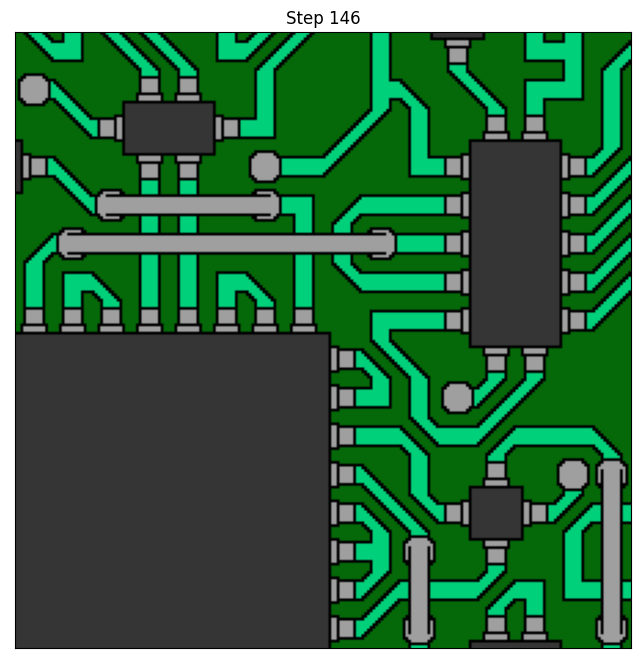

In [27]:
animate_history(circuit_tileset, patterns, states, "circuits.gif")